In [34]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Connetti al database MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["performance_modelli"]
collection = db["post"]

In [63]:

# Filtro per recuperare solo i documenti che contengono "gioia" con un punteggio > 0.5
query = {
    "ner": {
        "$elemMatch": {
            "entity": "SINTOMI NEUROPSICHIATRICI (B)"
        }
    }
}


In [64]:
# Recupera i documenti filtrati
documents = collection.find(query)

# Inizializza un dizionario con liste vuote per ogni emozione
emotion_scores = {}

# Itera sui documenti filtrati
for doc in documents:
    sentiment_analysis = doc.get("sentiment_analysis_full", {})
    
    for emotion, score in sentiment_analysis.items():
        if emotion not in emotion_scores:
            emotion_scores[emotion] = []  # Crea la lista se non esiste
        emotion_scores[emotion].append(score)  # Aggiunge lo score

In [55]:
def calculate_statistics(emotions_scores):
    stats = []
    for emotion, scores in emotions_scores.items():
        scores_array = np.array(scores)
        stats.append([
            emotion,
            np.min(scores_array),
            np.max(scores_array),
            np.mean(scores_array),
            np.median(scores_array),
            np.var(scores_array),
            pd.Series(scores_array).skew()
        ])
    df = pd.DataFrame(stats, columns=["Emozione", "Min", "Max", "Media", "Mediana", "Varianza", "Asimmetria"])
    return df

def plot_emotion_means(emotion_dict, plot_type='bar'):
    # Definisce i colori per le emozioni
    emotion_colors = {
        "gioia": "green", "ottimismo": "limegreen", "gratitudine": "lightgreen",
        "amore": "mediumseagreen", "curiosità": "yellowgreen",
        "tristezza": "red", "paura": "darkred", "rabbia": "crimson",
        "delusione": "orangered", "nervosismo": "tomato", "fastidio": "brown",
        "disgusto": "purple", "divertimento": "pink", "imbarazzo": "lightcoral",
        "neutrale": "gray", "confusione": "slategray", "realizzazione": "teal",
        "approvazione": "blue", "lutto": "black", "desiderio": "violet",
        "cura": "turquoise", "rilievo": "lightblue", "ammirazione": "gold",
        "rimorso": "indianred", "eccitazione": "orange", "sorpresa": "fuchsia",
        "orgoglio": "navy", "disapprovazione": "darkslategray"
    }
    
    # Calcola la media per ogni emozione
    emotions = list(emotion_dict.keys())
    means = [np.mean(emotion_dict[emotion]) for emotion in emotions]

    # Gestisce emozioni che non sono nel dizionario
    def get_color(emotion):
        return emotion_colors.get(emotion, "gray")  # Imposta colore di default "gray" per emozioni sconosciute

    colors = [get_color(emotion) for emotion in emotions]

    if plot_type == 'bar':
        # Grafico a barre
        plt.figure(figsize=(12, 6))
        plt.bar(emotions, means, color=colors)
        plt.xlabel("Emozioni")
        plt.ylabel("Media del punteggio")
        plt.title("Media dei punteggi per ogni emozione")
        plt.xticks(rotation=90)
        plt.show()

    elif plot_type == 'boxplot':
        # Converti il dizionario in un formato adatto per Seaborn (long format)
        data = []
        for emotion, values in emotion_dict.items():
            for value in values:
                data.append({'Emozione': emotion, 'Media': value})
        # Crea il DataFrame
        df = pd.DataFrame(data)
        
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='Emozione', y='Media', data=df, palette=emotion_colors)
        plt.xlabel("Emozioni")
        plt.ylabel("Punteggio")
        plt.title("Boxplot dei punteggi per ogni emozione")
        plt.xticks(rotation=90)
        plt.show()

    elif plot_type == 'kde':
        # Creiamo un grafico a distribuzione per ogni emozione (densità relativa)
        num_emotions = len(emotions)
        # Imposta un numero maggiore di colonne se ci sono molte emozioni
        ncols = 4  # Puoi modificare questo valore se necessario
        nrows = (num_emotions // ncols) + (num_emotions % ncols > 0)

        # Crea subplots per ogni emozione
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 6 * nrows), sharey=True)

        # Gestiamo il caso in cui ci sia solo una riga o una colonna di grafici
        axes = axes.flatten()

        for i, (ax, emotion) in enumerate(zip(axes, emotions)):
            sns.kdeplot(emotion_dict[emotion], ax=ax, label=emotion, color=get_color(emotion), common_norm=True)
            ax.set_title(emotion)
            ax.set_xlabel("Punteggio")
            ax.set_ylabel("Densità")
            ax.legend(title='Emozione')
        
        # Se il numero di grafici è inferiore alla quantità di subplots, nascondi quelli inutilizzati
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        plt.show()

    elif plot_type == "correlation":
         # Converto il dizionario in un DataFrame per l'analisi
        df = pd.DataFrame(emotion_dict)
    
        # Calcolare le correlazioni tra le emozioni
        correlation_matrix = df.corr()
        plt.figure(figsize=(17, 15))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title("Matrice di Correlazione tra Emozioni")
        plt.show()

    else:
        print("Tipo di grafico non riconosciuto. Usa 'bar', 'boxplot'. 'kde' 0 'correlation.")

In [62]:
table_statistics = calculate_statistics(emotion_scores)


C:\Users\lore9\AppData\Local\Temp\ipykernel_284\2389158980.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Emozione', y='Media', data=df, palette=emotion_colors)


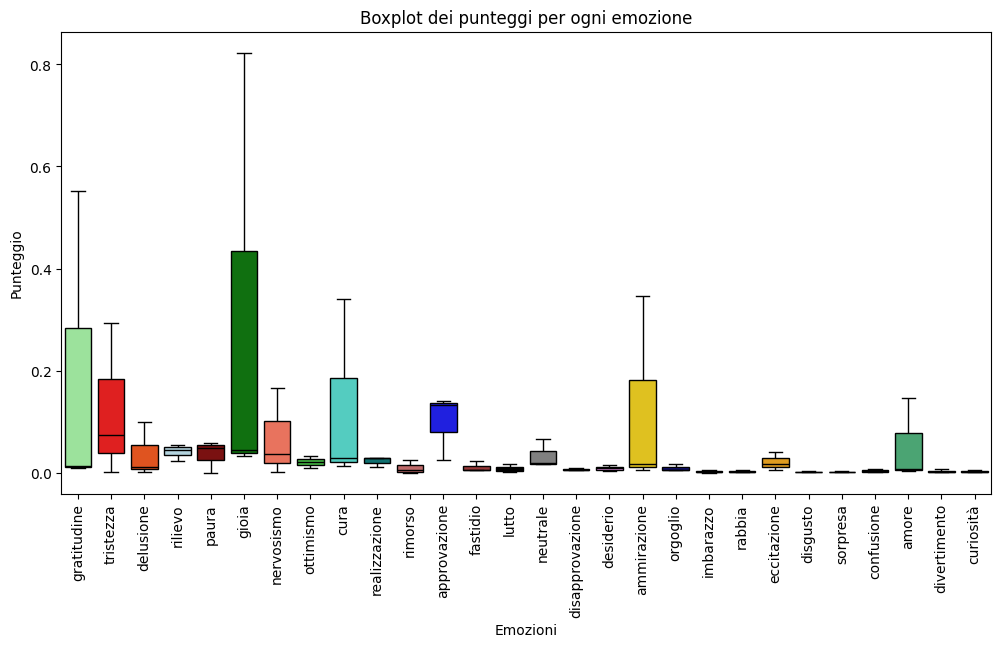

In [66]:
plot_emotion_means(emotion_scores, plot_type="boxplot")